<a href="https://colab.research.google.com/github/piotrciechowicz/fake_news_detection/blob/main/Fake_news_detection_DS_WELFake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score, classification_report, roc_curve, roc_auc_score

#!pip install pandas-profiling
#from pandas_profiling import ProfileReport
from pathlib import Path
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
!pip install optuna
import optuna

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Functions

In [2]:
stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(texts):
    output= [i for i in texts if i not in stopwords]
    return output

In [3]:
interpunction = ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', ':', ';', '<', '=', '>', '?', '@', '[', '', ']', '^', '_', '`', '{', '|', '}', '~']
def remove_interpunction(texts):
    output= [i for i in texts if i not in interpunction]
    return output

In [4]:
lemmatizer = WordNetLemmatizer()
def lemmatize(texts):
    lem_text = [lemmatizer.lemmatize(word) for word in texts]
    return lem_text

In [5]:
def test_model(X_test, y_test, model, criterion, optimizer, epochs):

  losses = []
  losses_test = []
  Iterations = []
  iter = 0


  with torch.no_grad():
    correct_test = 0
    total_test = 0
    outputs_test = torch.squeeze(model(X_test))
    loss_test = criterion(outputs_test, y_test)

    predicted_test = outputs_test.round().detach().numpy()
    total_test += y_test.size(0)
    correct_test += np.sum(predicted_test == y_test.detach().numpy())
    accuracy_test = 100 * correct_test/total_test
    losses_test.append(loss_test.item())

    print(f"Test - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")

In [6]:
def use_model(X_train, y_train, X_test, y_test, model, criterion, optimizer, epochs):

  losses = []
  losses_test = []
  Iterations = []
  iter = 0

  for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
      x = X_train
      labels = y_train
      optimizer.zero_grad() 
      outputs = model(X_train)
      loss = criterion(torch.squeeze(outputs), labels) 
      
      loss.backward() 
      
      optimizer.step() 
      
      iter+=1
      if iter%(epochs/5)==0:
          with torch.no_grad():
              correct_test = 0
              total_test = 0
              outputs_test = torch.squeeze(model(X_test))
              loss_test = criterion(outputs_test, y_test)
              
              predicted_test = outputs_test.round().detach().numpy()
              total_test += y_test.size(0)
              correct_test += np.sum(predicted_test == y_test.detach().numpy())
              accuracy_test = 100 * correct_test/total_test
              losses_test.append(loss_test.item())
              total = 0
              correct = 0
              total += y_train.size(0)
              correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
              accuracy = 100 * correct/total
              losses.append(loss.item())
              Iterations.append(iter)

              print(f"Iteration: {iter}. \nVal - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
              print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
  return accuracy

In [7]:
def reset_weights(m):
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [8]:
def validation_with_StratifiedKFold(X_train, y_train, X_val, y_val, X_test, y_test, 
                                    n_splits, model, criterion, optimizer, epochs):

  skf = StratifiedKFold(n_splits=n_splits, shuffle = True, random_state = 8)

  for fold,(train_idx,test_idx) in enumerate(skf.split(X_train, y_train)):

    print('\n')   
    print('------------fold no---------{}----------------------'.format(fold))
    print('\n')   

    x_train_fold, x_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    model_lr.apply(reset_weights)
    
    print('\n')    
    print('Fit model on train part of dataset')
    print('\n')  
    use_model(x_train_fold, y_train_fold, x_test_fold, y_test_fold, 
               model, criterion, 
               optimizer, epochs)
    
    print('\n')
    print('Evaluation model on validation part of dataset')
    print('\n')  
    test_model(X_val, y_val, 
               model, criterion, 
               optimizer, epochs)
    
    print('\n')
    print('Evaluation model on test part of dataset')
    print('\n') 
    test_model(X_test, y_test, 
               model, criterion, 
               optimizer, epochs)

#Importing dataset

In [9]:
path_welfake = '/content/drive/MyDrive/Colab Notebooks/Codecool/SI week 2/WELFake/WELFake_Dataset.csv'
df = pd.read_csv(path_welfake)

In [10]:
df.sample(3)

,Unnamed: 0,title,text,label
20745,20745,CBS HIT JOB On New Tax Bill Backfires When Acc...,For weeks and weeks we ve heard the propaganda...,1
7214,7214,"Factbox: How Senate, House Obamacare overhaul ...",(Reuters) - After weeks of discussions behind ...,0
11918,11918,America’s looming freak show: How GOP control ...,Bill Scher made the argument from the left as ...,0


# Exploratory data analysis

In [11]:
df = df.rename({'label': 'is_real'}, axis='columns')

In [12]:
df_2 = df.drop(['Unnamed: 0'],axis=1)

In [13]:
print('Shape:')
print(df_2.shape)
print('-'*80, '\n')
print('Duplicates:')
print(df_2.duplicated().sum())
print('-'*80, '\n')
print('Missing values:')
print(df_2.isnull().sum())
print('-'*80, '\n')

Shape:
(72134, 3)
-------------------------------------------------------------------------------- 

Duplicates:
8456
-------------------------------------------------------------------------------- 

Missing values:
title      558
text        39
is_real      0
dtype: int64
-------------------------------------------------------------------------------- 



In [14]:
df_2 = df_2.drop_duplicates()

In [15]:
df_3 = df_2.dropna(axis='index')

0    34791
1    28330
Name: is_real, dtype: int64
-------------------------------------------------------------------------------- 



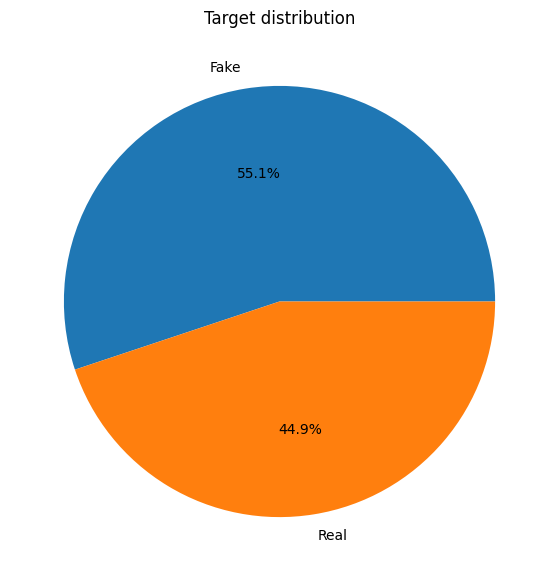

In [16]:
print(df_3['is_real'].value_counts())
print('-'*80, '\n')
fig, ax = plt.subplots(figsize = (7,7))
ax.pie(df_3['is_real'].value_counts(),labels=['Fake','Real'], autopct='%1.1f%%')
ax.set_title('Target distribution')
plt.show()

#Pandas profiling

In [17]:
#prof = ProfileReport(df_2)
#prof.to_file(Path("/content/drive/MyDrive/Colab Notebooks/Codecool/SI week 2/pandas_profiling_report_welfake.html"))

#Feature engeneering

##Downsampling

In [18]:
df_3_fake = df_3[df_3['is_real']==0]
df_3_true = df_3[df_3['is_real']==1]

In [19]:
df_3_fake_downsample = resample(df_3_fake,
             replace=True,
             n_samples=len(df_3_true),
             random_state=42)

In [20]:
data = pd.concat([df_3_fake_downsample,df_3_true], ignore_index = True)

In [21]:
print(data['is_real'].value_counts())
print('-'*80, '\n')

0    28330
1    28330
Name: is_real, dtype: int64
-------------------------------------------------------------------------------- 



In [22]:
X_0 = data['title'] + data['text']
y = data['is_real']

##Lowering the text

In [23]:
X_low = X_0.map(lambda x: x.lower())

##Tokenization

In [24]:
X_tokenize = X_low.map(lambda x: word_tokenize(x))

##Removing stopwords

In [25]:
X_stopwords = X_tokenize.map(lambda x: remove_stopwords(x))

##Removing interpuntion

In [26]:
X_interpunction = X_stopwords.map(lambda x: remove_interpunction(x))

##Converting words to lemma

In [27]:
X_lemmatize = X_interpunction.map(lambda x: lemmatize(x))

#WordCloud

In [28]:
X = X_lemmatize.astype(str)

In [38]:
X_wc = X[0:1000]

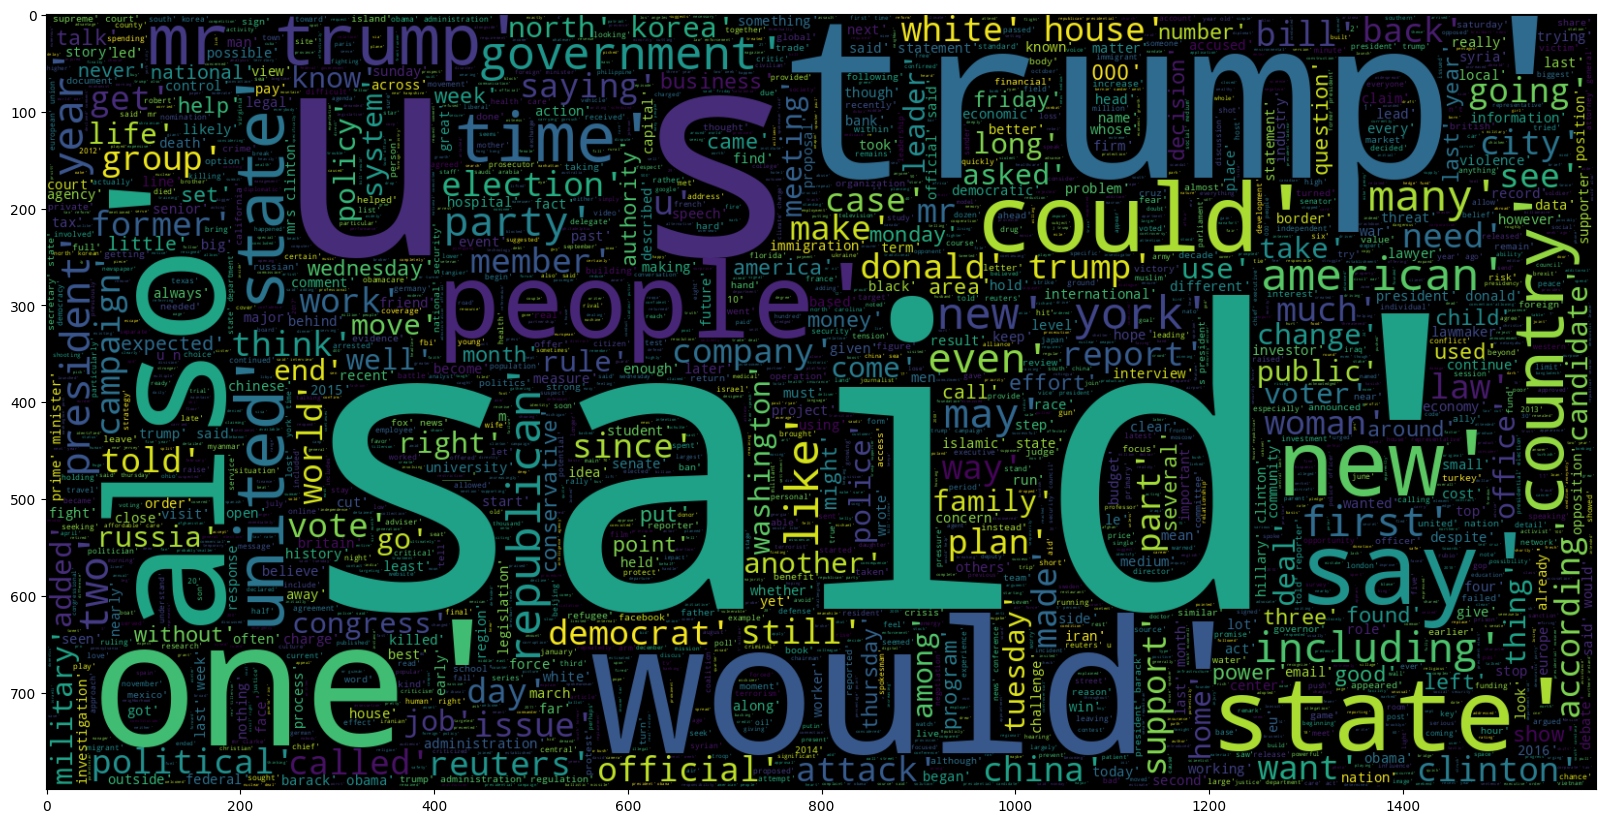

In [39]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(X_wc))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

#Modeling

##Split dataset

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.8, random_state = 8, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 8, stratify=y_test)

##TfidfVectorizer

In [32]:
tfidf = TfidfVectorizer(max_features=100)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
X_val_tfidf = tfidf.transform(X_val)

#Logistic Regression with PyTorch

###Model logistic regression

In [33]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

In [34]:
input_dim = X_train_tfidf.shape[1]
output_dim = 1
learning_rate = 0.01

In [35]:
model_lr = LogisticRegression(input_dim,output_dim)
criterion_lr = torch.nn.BCELoss()
optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

In [36]:
X_train_py, X_val_py, X_test_py = torch.Tensor(X_train_tfidf.toarray()),torch.Tensor(X_val_tfidf.toarray()),torch.Tensor(X_test_tfidf.toarray())
y_train_py, y_val_py, y_test_py = torch.Tensor(y_train.to_numpy()),torch.Tensor(y_val.to_numpy()),torch.Tensor(y_test.to_numpy())

In [37]:
use_model(X_train_py, y_train_py, X_val_py, y_val_py,
          model = model_lr, criterion = criterion_lr, 
          optimizer = optimizer_lr, epochs = 10000)

Training Epochs:  21%|██        | 2104/10000 [00:02<00:08, 950.23it/s]

Iteration: 2000. 
Val - Loss: 0.6202663779258728. Accuracy: 80.50653018002117
Train -  Loss: 0.6191310882568359. Accuracy: 81.46840804800564



Training Epochs:  42%|████▏     | 4168/10000 [00:05<00:06, 960.20it/s]

Iteration: 4000. 
Val - Loss: 0.5681968331336975. Accuracy: 82.06406636074833
Train -  Loss: 0.5661040544509888. Accuracy: 82.75679491704906



Training Epochs:  62%|██████▏   | 6173/10000 [00:07<00:04, 916.01it/s]

Iteration: 6000. 
Val - Loss: 0.5303781032562256. Accuracy: 82.79650547123191
Train -  Loss: 0.5275703072547913. Accuracy: 83.44511118955171



Training Epochs:  81%|████████  | 8098/10000 [00:09<00:02, 885.19it/s]

Iteration: 8000. 
Val - Loss: 0.5019626021385193. Accuracy: 83.3083303918108
Train -  Loss: 0.49859699606895447. Accuracy: 83.79809389339923



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 885.92it/s]

Iteration: 10000. 
Val - Loss: 0.479962021112442. Accuracy: 83.70984821743734
Train -  Loss: 0.4761447608470917. Accuracy: 84.14225202965055



84.14225202965055

###Optuna

In [40]:
def objective(trial):

  input_dim = X_train_tfidf.shape[1]
  output_dim = 1

  param = {'lr': trial.suggest_loguniform('lr', 0.02, 0.1)}

  model_lr = LogisticRegression(input_dim,output_dim)
  criterion_lr = torch.nn.BCELoss()
  optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=learning_rate)

  accuracy = use_model(X_train_py, y_train_py, X_val_py, y_val_py, 
          model = model_lr, criterion = criterion_lr, 
          optimizer = optimizer_lr, epochs = 10000)

  return accuracy

In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5, timeout=600)

[I 2023-04-17 18:07:13,835] A new study created in memory with name: no-name-90ff57eb-dce4-44cd-906b-8d9b2872bea0
<ipython-input-40-eca541b33e7e>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  param = {'lr': trial.suggest_loguniform('lr', 0.02, 0.1)}
Training Epochs:  21%|██        | 2124/10000 [00:02<00:09, 851.71it/s]

Iteration: 2000. 
Val - Loss: 0.6174180507659912. Accuracy: 82.70384751147193
Train -  Loss: 0.6160759329795837. Accuracy: 83.04800564772326



Training Epochs:  42%|████▏     | 4165/10000 [00:04<00:06, 876.40it/s]

Iteration: 4000. 
Val - Loss: 0.565610945224762. Accuracy: 83.06565478291564
Train -  Loss: 0.563364565372467. Accuracy: 83.41863748676315



Training Epochs:  61%|██████▏   | 6134/10000 [00:06<00:04, 906.48it/s]

Iteration: 6000. 
Val - Loss: 0.5281437635421753. Accuracy: 83.35245322979173
Train -  Loss: 0.5252255201339722. Accuracy: 83.71867278503353



Training Epochs:  81%|████████  | 8062/10000 [00:10<00:03, 532.10it/s]

Iteration: 8000. 
Val - Loss: 0.5000669360160828. Accuracy: 83.63925167666784
Train -  Loss: 0.49662521481513977. Accuracy: 83.99223438051536



Training Epochs: 100%|██████████| 10000/10000 [00:12<00:00, 793.98it/s]
[I 2023-04-17 18:07:26,445] Trial 0 finished with value: 84.22167313801624 and parameters: {'lr': 0.0958934399311151}. Best is trial 0 with value: 84.22167313801624.


Iteration: 10000. 
Val - Loss: 0.4783603250980377. Accuracy: 83.96576067772679
Train -  Loss: 0.4744940996170044. Accuracy: 84.22167313801624



Training Epochs:  22%|██▏       | 2177/10000 [00:02<00:08, 891.49it/s]

Iteration: 2000. 
Val - Loss: 0.6174169182777405. Accuracy: 81.79932933286268
Train -  Loss: 0.6165596842765808. Accuracy: 82.09495234733498



Training Epochs:  42%|████▏     | 4186/10000 [00:04<00:06, 952.60it/s]

Iteration: 4000. 
Val - Loss: 0.5658830404281616. Accuracy: 82.62442640310624
Train -  Loss: 0.5641013979911804. Accuracy: 83.13625132368514



Training Epochs:  61%|██████    | 6101/10000 [00:06<00:03, 979.70it/s]

Iteration: 6000. 
Val - Loss: 0.5284878015518188. Accuracy: 83.13625132368514
Train -  Loss: 0.5260100364685059. Accuracy: 83.49805859512884



Training Epochs:  80%|████████  | 8049/10000 [00:08<00:02, 738.96it/s]

Iteration: 8000. 
Val - Loss: 0.5003939867019653. Accuracy: 83.51129544652312
Train -  Loss: 0.4973680078983307. Accuracy: 83.92163783974586



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 834.79it/s]
[I 2023-04-17 18:07:38,435] Trial 1 finished with value: 84.08048005647723 and parameters: {'lr': 0.08049155288933353}. Best is trial 0 with value: 84.22167313801624.


Iteration: 10000. 
Val - Loss: 0.4786352515220642. Accuracy: 83.87751500176492
Train -  Loss: 0.4751613438129425. Accuracy: 84.08048005647723



Training Epochs:  22%|██▏       | 2184/10000 [00:02<00:08, 950.92it/s]

Iteration: 2000. 
Val - Loss: 0.6211094856262207. Accuracy: 81.73755735968938
Train -  Loss: 0.6197390556335449. Accuracy: 82.04200494175785



Training Epochs:  41%|████▏     | 4132/10000 [00:04<00:06, 885.08it/s]

Iteration: 4000. 
Val - Loss: 0.5684396624565125. Accuracy: 82.52735615954818
Train -  Loss: 0.5661595463752747. Accuracy: 83.03918108012708



Training Epochs:  62%|██████▏   | 6158/10000 [00:06<00:04, 911.35it/s]

Iteration: 6000. 
Val - Loss: 0.5302988886833191. Accuracy: 83.18037416166608
Train -  Loss: 0.5273414254188538. Accuracy: 83.63925167666784



Training Epochs:  81%|████████▏ | 8137/10000 [00:09<00:02, 882.72it/s]

Iteration: 8000. 
Val - Loss: 0.5017148852348328. Accuracy: 83.5245322979174
Train -  Loss: 0.49822914600372314. Accuracy: 83.91281327214966



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 870.27it/s]
[I 2023-04-17 18:07:49,938] Trial 2 finished with value: 84.19519943522768 and parameters: {'lr': 0.026192828483357636}. Best is trial 0 with value: 84.22167313801624.


Iteration: 10000. 
Val - Loss: 0.4796298146247864. Accuracy: 83.75838333921638
Train -  Loss: 0.47571563720703125. Accuracy: 84.19519943522768



Training Epochs:  21%|██        | 2112/10000 [00:03<00:08, 881.66it/s]

Iteration: 2000. 
Val - Loss: 0.6181937456130981. Accuracy: 80.72714436992587
Train -  Loss: 0.616752028465271. Accuracy: 81.08895164136958



Training Epochs:  41%|████▏     | 4143/10000 [00:05<00:06, 925.81it/s]

Iteration: 4000. 
Val - Loss: 0.5669727325439453. Accuracy: 82.12583833392164
Train -  Loss: 0.5646482706069946. Accuracy: 82.73914578185669



Training Epochs:  61%|██████▏   | 6130/10000 [00:07<00:04, 886.44it/s]

Iteration: 6000. 
Val - Loss: 0.5296726822853088. Accuracy: 82.77444405224144
Train -  Loss: 0.52668696641922. Accuracy: 83.3833392163784



Training Epochs:  81%|████████▏ | 8149/10000 [00:09<00:02, 913.89it/s]

Iteration: 8000. 
Val - Loss: 0.5015854835510254. Accuracy: 83.22449699964702
Train -  Loss: 0.4980809986591339. Accuracy: 83.61277797387928



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 837.78it/s]
[I 2023-04-17 18:08:01,881] Trial 3 finished with value: 83.98340981291916 and parameters: {'lr': 0.09252369416025372}. Best is trial 0 with value: 84.22167313801624.


Iteration: 10000. 
Val - Loss: 0.4798000156879425. Accuracy: 83.61719025767738
Train -  Loss: 0.4758731722831726. Accuracy: 83.98340981291916



Training Epochs:  20%|██        | 2050/10000 [00:03<00:13, 583.43it/s]

Iteration: 2000. 
Val - Loss: 0.6186367273330688. Accuracy: 81.73755735968938
Train -  Loss: 0.6174059510231018. Accuracy: 81.83021531944935



Training Epochs:  41%|████      | 4121/10000 [00:06<00:06, 894.48it/s]

Iteration: 4000. 
Val - Loss: 0.5668824911117554. Accuracy: 82.61118955171196
Train -  Loss: 0.5647385120391846. Accuracy: 82.95975997176139



Training Epochs:  62%|██████▏   | 6170/10000 [00:08<00:04, 923.02it/s]

Iteration: 6000. 
Val - Loss: 0.5293260216712952. Accuracy: 83.19361101306036
Train -  Loss: 0.5265018343925476. Accuracy: 83.5333568655136



Training Epochs:  81%|████████  | 8110/10000 [00:10<00:01, 951.44it/s]

Iteration: 8000. 
Val - Loss: 0.5011173486709595. Accuracy: 83.50247087892693
Train -  Loss: 0.4977620542049408. Accuracy: 83.8157430285916



Training Epochs: 100%|██████████| 10000/10000 [00:12<00:00, 810.75it/s]
[I 2023-04-17 18:08:14,225] Trial 4 finished with value: 84.15107659724673 and parameters: {'lr': 0.02430734757696859}. Best is trial 0 with value: 84.22167313801624.


Iteration: 10000. 
Val - Loss: 0.47927647829055786. Accuracy: 83.8069184609954
Train -  Loss: 0.47549015283584595. Accuracy: 84.15107659724673



In [42]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 5
Best trial:
  Value: 84.22167313801624
  Params: 
    lr: 0.0958934399311151


###StratifiedKFold

In [43]:
lr_best = trial.params['lr']
input_dim = X_train_tfidf.shape[1]
output_dim = 1
lr = lr_best

model_lr = LogisticRegression(input_dim,output_dim)
criterion_lr = torch.nn.BCELoss()
optimizer_lr = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [44]:
validation_with_StratifiedKFold(X_train_py, y_train_py,
                                X_val_py, y_val_py, 
                                X_test_py, y_test_py, 
                                n_splits = 5, model = model_lr, 
                                criterion = criterion_lr, optimizer = optimizer_lr, epochs = 10000)



------------fold no---------0----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██        | 2115/10000 [00:01<00:07, 1062.54it/s]

Iteration: 2000. 
Val - Loss: 0.4210534691810608. Accuracy: 85.31098367887076
Train -  Loss: 0.4156288504600525. Accuracy: 84.96414782129068



Training Epochs:  41%|████      | 4082/10000 [00:04<00:08, 716.18it/s]

Iteration: 4000. 
Val - Loss: 0.37550532817840576. Accuracy: 86.32554036171152
Train -  Loss: 0.3676314651966095. Accuracy: 85.68119139547711



Training Epochs:  62%|██████▏   | 6213/10000 [00:07<00:03, 1067.63it/s]

Iteration: 6000. 
Val - Loss: 0.35648831725120544. Accuracy: 86.6784296426996
Train -  Loss: 0.3472146689891815. Accuracy: 86.27688913403199



Training Epochs:  82%|████████▏ | 8216/10000 [00:09<00:01, 1071.77it/s]

Iteration: 8000. 
Val - Loss: 0.3454238176345825. Accuracy: 86.72254080282312
Train -  Loss: 0.3352912366390228. Accuracy: 86.57473800330943



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 914.15it/s]


Iteration: 10000. 
Val - Loss: 0.3378502428531647. Accuracy: 86.63431848257609
Train -  Loss: 0.3271833658218384. Accuracy: 86.79536679536679



Evaluation model on validation part of dataset


Test - Loss: 0.3383469879627228. Accuracy: 86.30427109071655


Evaluation model on test part of dataset


Test - Loss: 0.33854132890701294. Accuracy: 86.2027885633604


------------fold no---------1----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██        | 2120/10000 [00:02<00:07, 1045.22it/s]

Iteration: 2000. 
Val - Loss: 0.41671955585479736. Accuracy: 84.95809439788266
Train -  Loss: 0.4146063029766083. Accuracy: 85.0965250965251



Training Epochs:  41%|████▏     | 4149/10000 [00:04<00:05, 1050.20it/s]

Iteration: 4000. 
Val - Loss: 0.3708992004394531. Accuracy: 85.17865019850022
Train -  Loss: 0.36759623885154724. Accuracy: 86.01213458356315



Training Epochs:  61%|██████    | 6113/10000 [00:06<00:05, 757.79it/s]

Iteration: 6000. 
Val - Loss: 0.3515891134738922. Accuracy: 85.57565063961182
Train -  Loss: 0.34767627716064453. Accuracy: 86.32101489244346



Training Epochs:  81%|████████▏ | 8125/10000 [00:09<00:02, 627.19it/s]

Iteration: 8000. 
Val - Loss: 0.3403136432170868. Accuracy: 86.32554036171152
Train -  Loss: 0.33604782819747925. Accuracy: 86.71814671814671



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 909.74it/s]


Iteration: 10000. 
Val - Loss: 0.3326062262058258. Accuracy: 86.41376268195853
Train -  Loss: 0.3281281888484955. Accuracy: 86.861555432984



Evaluation model on validation part of dataset


Test - Loss: 0.33817344903945923. Accuracy: 86.24249911754325


Evaluation model on test part of dataset


Test - Loss: 0.33817532658576965. Accuracy: 86.31750794211084


------------fold no---------2----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██▏       | 2143/10000 [00:02<00:07, 1078.93it/s]

Iteration: 2000. 
Val - Loss: 0.4138406217098236. Accuracy: 84.90732568402471
Train -  Loss: 0.41669943928718567. Accuracy: 85.16435031987646



Training Epochs:  42%|████▏     | 4185/10000 [00:04<00:05, 1048.92it/s]

Iteration: 4000. 
Val - Loss: 0.3676922023296356. Accuracy: 85.5251544571933
Train -  Loss: 0.3689693808555603. Accuracy: 85.68277079197



Training Epochs:  61%|██████▏   | 6136/10000 [00:05<00:03, 1035.52it/s]

Iteration: 6000. 
Val - Loss: 0.3484968841075897. Accuracy: 85.87819947043248
Train -  Loss: 0.34859010577201843. Accuracy: 86.33355393778955



Training Epochs:  82%|████████▏ | 8167/10000 [00:07<00:01, 1071.85it/s]

Iteration: 8000. 
Val - Loss: 0.33744069933891296. Accuracy: 86.31950573698147
Train -  Loss: 0.3366178274154663. Accuracy: 86.62033973086257



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 968.17it/s]


Iteration: 10000. 
Val - Loss: 0.3299919068813324. Accuracy: 86.67255075022065
Train -  Loss: 0.32842472195625305. Accuracy: 86.71961173615708



Evaluation model on validation part of dataset


Test - Loss: 0.33771347999572754. Accuracy: 86.29103423932227


Evaluation model on test part of dataset


Test - Loss: 0.3385776877403259. Accuracy: 86.2733851041299


------------fold no---------3----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██▏       | 2136/10000 [00:02<00:07, 1104.56it/s]

Iteration: 2000. 
Val - Loss: 0.4217248857021332. Accuracy: 83.62753751103266
Train -  Loss: 0.4151431918144226. Accuracy: 85.23053165673947



Training Epochs:  42%|████▏     | 4165/10000 [00:04<00:05, 1096.35it/s]

Iteration: 4000. 
Val - Loss: 0.3745768070220947. Accuracy: 85.12797881729921
Train -  Loss: 0.3675868809223175. Accuracy: 86.03573792190602



Training Epochs:  62%|██████▏   | 6164/10000 [00:06<00:03, 1071.26it/s]

Iteration: 6000. 
Val - Loss: 0.35485678911209106. Accuracy: 85.3927625772286
Train -  Loss: 0.3471303880214691. Accuracy: 86.31149349216854



Training Epochs:  81%|████████  | 8121/10000 [00:08<00:01, 1031.10it/s]

Iteration: 8000. 
Val - Loss: 0.34363946318626404. Accuracy: 85.92233009708738
Train -  Loss: 0.33502456545829773. Accuracy: 86.53209794837856



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 999.53it/s]


Iteration: 10000. 
Val - Loss: 0.33623749017715454. Accuracy: 86.09885260370697
Train -  Loss: 0.3266878128051758. Accuracy: 86.87403485550408



Evaluation model on validation part of dataset


Test - Loss: 0.3377532660961151. Accuracy: 86.23808683374514


Evaluation model on test part of dataset


Test - Loss: 0.33812642097473145. Accuracy: 86.18513942816801


------------fold no---------4----------------------


Reset trainable parameters of layer = Linear(in_features=100, out_features=1, bias=True)


Fit model on train part of dataset




Training Epochs:  21%|██        | 2104/10000 [00:02<00:10, 789.18it/s]

Iteration: 2000. 
Val - Loss: 0.4162665009498596. Accuracy: 85.3486319505737
Train -  Loss: 0.4164125919342041. Accuracy: 84.72314140745642



Training Epochs:  41%|████      | 4061/10000 [00:05<00:10, 579.86it/s]

Iteration: 4000. 
Val - Loss: 0.36911123991012573. Accuracy: 86.18711385701677
Train -  Loss: 0.36942651867866516. Accuracy: 85.550408118244



Training Epochs:  61%|██████    | 6104/10000 [00:07<00:03, 1053.24it/s]

Iteration: 6000. 
Val - Loss: 0.34910643100738525. Accuracy: 85.96646072374227
Train -  Loss: 0.34920307993888855. Accuracy: 86.15707037282154



Training Epochs:  81%|████████▏ | 8146/10000 [00:09<00:01, 1045.55it/s]

Iteration: 8000. 
Val - Loss: 0.3375430107116699. Accuracy: 85.92233009708738
Train -  Loss: 0.3372421860694885. Accuracy: 86.37767482903155



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 890.67it/s]

Iteration: 10000. 
Val - Loss: 0.32978639006614685. Accuracy: 86.23124448367167
Train -  Loss: 0.32901957631111145. Accuracy: 86.66446062210457



Evaluation model on validation part of dataset


Test - Loss: 0.3382854461669922. Accuracy: 86.22484998235086


Evaluation model on test part of dataset


Test - Loss: 0.3390008211135864. Accuracy: 86.17190257677373


###Without cutting "stopwords'

In [45]:
X_interpunction_2 = X_tokenize.map(lambda x: remove_interpunction(x))
X_lemmatize_2 = X_interpunction_2.map(lambda x: lemmatize(x))
X_2 = X_lemmatize_2.astype(str)

X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_2,y, test_size = 0.8, random_state = 8, stratify=y)

tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf_2 = tfidf.fit_transform(X_train_2)
X_val_tfidf_2 = tfidf.transform(X_val_2)

In [46]:
input_dim = X_train_tfidf_2.shape[1]
output_dim = 1
lr = lr_best

model_lr_2 = LogisticRegression(input_dim,output_dim)
criterion_lr_2 = torch.nn.BCELoss()
optimizer_lr_2 = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [47]:
X_train_py_2, X_val_py_2 = torch.Tensor(X_train_tfidf_2.toarray()),torch.Tensor(X_val_tfidf_2.toarray())
y_train_py_2, y_val_py_2 = torch.Tensor(y_train_2.to_numpy()),torch.Tensor(y_val_2.to_numpy())

In [48]:
use_model(X_train_py_2, y_train_py_2, X_val_py_2, y_val_py_2,
          model = model_lr_2, criterion = criterion_lr_2, 
          optimizer = optimizer_lr_2, epochs = 10000)

Training Epochs:  21%|██        | 2053/10000 [00:03<00:14, 537.17it/s]

Iteration: 2000. 
Val - Loss: 0.6966705918312073. Accuracy: 48.120367102012004
Train -  Loss: 0.6966416835784912. Accuracy: 48.36745499470526



Training Epochs:  42%|████▏     | 4205/10000 [00:05<00:05, 1019.87it/s]

Iteration: 4000. 
Val - Loss: 0.6966705918312073. Accuracy: 48.120367102012004
Train -  Loss: 0.6966416835784912. Accuracy: 48.36745499470526



Training Epochs:  62%|██████▏   | 6165/10000 [00:07<00:03, 997.91it/s] 

Iteration: 6000. 
Val - Loss: 0.6966705918312073. Accuracy: 48.120367102012004
Train -  Loss: 0.6966416835784912. Accuracy: 48.36745499470526



Training Epochs:  81%|████████  | 8113/10000 [00:09<00:01, 974.09it/s]

Iteration: 8000. 
Val - Loss: 0.6966705918312073. Accuracy: 48.120367102012004
Train -  Loss: 0.6966416835784912. Accuracy: 48.36745499470526



Training Epochs: 100%|██████████| 10000/10000 [00:11<00:00, 844.42it/s]

Iteration: 10000. 
Val - Loss: 0.6966705918312073. Accuracy: 48.120367102012004
Train -  Loss: 0.6966416835784912. Accuracy: 48.36745499470526



48.36745499470526

###Without lemmatization

In [49]:
X_3 = X_interpunction.astype(str)

X_train_3, X_val_3, y_train_3, y_val_3 = train_test_split(X_3,y, test_size = 0.8, random_state = 8, stratify=y)

tfidf = TfidfVectorizer(max_features=100)
X_train_tfidf_3 = tfidf.fit_transform(X_train_3)
X_val_tfidf_3 = tfidf.transform(X_val_3)

In [50]:
input_dim = X_train_tfidf_3.shape[1]
output_dim = 1
lr = lr_best

model_lr_3 = LogisticRegression(input_dim,output_dim)
criterion_lr_3 = torch.nn.BCELoss()
optimizer_lr_3 = torch.optim.SGD(model_lr.parameters(), lr=lr)

In [51]:
X_train_py_3, X_val_py_3 = torch.Tensor(X_train_tfidf_3.toarray()),torch.Tensor(X_val_tfidf_3.toarray())
y_train_py_3, y_val_py_3 = torch.Tensor(y_train_3.to_numpy()),torch.Tensor(y_val_3.to_numpy())

In [52]:
use_model(X_train_py_3, y_train_py_3, X_val_py_3, y_val_py_3,
          model = model_lr_3, criterion = criterion_lr_3, 
          optimizer = optimizer_lr_3, epochs = 10000)

Training Epochs:  21%|██▏       | 2141/10000 [00:02<00:08, 940.06it/s]

Iteration: 2000. 
Val - Loss: 0.6920561790466309. Accuracy: 50.92657959759972
Train -  Loss: 0.6922017335891724. Accuracy: 50.450052947405574



Training Epochs:  41%|████      | 4121/10000 [00:04<00:06, 958.77it/s]

Iteration: 4000. 
Val - Loss: 0.6920561790466309. Accuracy: 50.92657959759972
Train -  Loss: 0.6922017335891724. Accuracy: 50.450052947405574



Training Epochs:  61%|██████▏   | 6134/10000 [00:06<00:04, 903.91it/s]

Iteration: 6000. 
Val - Loss: 0.6920561790466309. Accuracy: 50.92657959759972
Train -  Loss: 0.6922017335891724. Accuracy: 50.450052947405574



Training Epochs:  82%|████████▏ | 8167/10000 [00:08<00:01, 995.74it/s]

Iteration: 8000. 
Val - Loss: 0.6920561790466309. Accuracy: 50.92657959759972
Train -  Loss: 0.6922017335891724. Accuracy: 50.450052947405574



Training Epochs: 100%|██████████| 10000/10000 [00:10<00:00, 917.79it/s]

Iteration: 10000. 
Val - Loss: 0.6920561790466309. Accuracy: 50.92657959759972
Train -  Loss: 0.6922017335891724. Accuracy: 50.450052947405574



50.450052947405574

#Deeper neutral network

In [53]:
class DeeperNN(nn.Module):

  def __init__(self, input_dim, output_dim):
      super().__init__()
      self.layer1 = nn.Linear(input_dim, 60)
      self.act1 = nn.ReLU()
      self.layer2 = nn.Linear(60, 60)
      self.act2 = nn.ReLU()
      self.layer3 = nn.Linear(60, 60)
      self.act3 = nn.ReLU()
      self.output = nn.Linear(60, output_dim)
      self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      x = self.act1(self.layer1(x))
      x = self.act2(self.layer2(x))
      x = self.act3(self.layer3(x))
      x = self.sigmoid(self.output(x))
      return x

In [54]:
input_dim = X_train_tfidf.shape[1]
output_dim = 1
lr = lr_best

model_nn = DeeperNN(input_dim,output_dim)
criterion_nn = torch.nn.BCELoss()
optimizer_nn = torch.optim.SGD(model_nn.parameters(), lr=lr)

In [55]:
use_model(X_train_py, y_train_py, X_val_py, y_val_py,
          model = model_nn, criterion = criterion_nn, 
          optimizer = optimizer_nn, epochs = 10000)

Training Epochs:  20%|██        | 2007/10000 [00:47<03:00, 44.32it/s]

Iteration: 2000. 
Val - Loss: 0.290957510471344. Accuracy: 88.27214966466643
Train -  Loss: 0.2732600271701813. Accuracy: 88.20155312389693



Training Epochs:  40%|████      | 4005/10000 [01:34<02:13, 45.04it/s]

Iteration: 4000. 
Val - Loss: 0.2774960994720459. Accuracy: 88.73543946346629
Train -  Loss: 0.223638117313385. Accuracy: 90.91069537592658



Training Epochs:  60%|██████    | 6008/10000 [02:20<01:27, 45.82it/s]

Iteration: 6000. 
Val - Loss: 0.3242490887641907. Accuracy: 88.06036004235793
Train -  Loss: 0.2049447000026703. Accuracy: 91.71373102717966



Training Epochs:  80%|████████  | 8008/10000 [03:08<00:47, 42.35it/s]

Iteration: 8000. 
Val - Loss: 0.2881651222705841. Accuracy: 89.5958348040946
Train -  Loss: 0.1066572368144989. Accuracy: 96.58489234027533



Training Epochs: 100%|██████████| 10000/10000 [03:54<00:00, 42.64it/s]

Iteration: 10000. 
Val - Loss: 0.3164411187171936. Accuracy: 89.25167666784327
Train -  Loss: 0.07429981976747513. Accuracy: 97.98799858806919



97.98799858806919

#Similar news

In [56]:
X_emb = X[0:100]

In [57]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(X_emb)

In [58]:
cos_sim = util.cos_sim(embeddings, embeddings)

all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)

print("Top-5 most similar pairs:")
for score, i, j in all_sentence_combinations[0:5]:
    print("{} \t {} \t {:.4f}".format(X_emb[i], X_emb[j], cos_sim[i][j]))

Top-5 most similar pairs:
["'s", 'final', 'republican', 'tax', 'bill', 'reuters', 'u.s.', 'house', 'representative', 'gave', 'final', 'approval', 'wednesday', 'sweeping', 'debt-financed', 'tax', 'bill', 'midday', 'vote', 'go', 'president', 'donald', 'trump', 'sign', 'law', 'although', 'timing', 'unclear', 'senate', 'approved', 'bill', 'early', 'wednesday', 'key', 'part', 'bill', 'representing', 'biggest', 'overhaul', 'u.s.', 'tax', 'code', '30', 'year', 'corporate', 'tax', 'rate', 'cut', 'corporate', 'income', 'tax', 'rate', 'permanently', '21', 'percent', '35', 'percent', 'jan.', '1', '2018.', 'pass-through', 'creates', '20', 'percent', 'deduction', 'first', '315,000', 'qualified', 'business', 'income', 'joint', 'filer', 'pass-through', 'business', 'partnership', 'sole', 'proprietorship', 'income', 'threshold', 'legislation', 'phase', 'limit', 'producing', 'effective', 'marginal', 'tax', 'rate', '29.6', 'percent', 'corporate', 'alternative', 'minimum', 'tax', 'repeal', '20', 'percent'